In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import theano.tensor as tt
import arviz as az
from sklearn.preprocessing import LabelEncoder

Function name: read_phs

Description: 

Read in player hero status from the given path.

Drop unwanted column.

We don't need All Hero data, so drop the All Hero row

Change column name from 'esports_match_id' to 'match_id' to unified 
Inputs:

1. path [string]: The path for player hero status data csv file.

Outputs:

1. player hero status [pandas.dataframe]: The player hero status dataframe after processing

In [2]:
def read_phs(path):
  phs = pd.read_csv(path)
  phs = phs.drop(labels=['start_time','tournament_title','map_type','player_name'],axis=1)
  phs = phs[phs.hero_name != 'All Heroes']
  phs = phs.rename(columns={'esports_match_id':'match_id'})
  return phs

Function name: read_map

Description: 

Read in player hero status from the given path and given stage name.

Drop unwanted column.

Drop and only keep the last row for one map in every match. We only need the final result for one map.

Inputs:

1. path [string]: The path for map status csv file.
2. stage [string]: The stage name. Use for get subset from origin. If leave to None, will return the whole data set.

Outputs:

1. maps [pandas.dataframe]: return the maps dataframe after processing

In [3]:
def read_map(path, stage):
  maps = pd.read_csv(path)
  if stage != None:
    maps = maps[maps.stage==stage]
  maps = maps.drop(labels=[
                         'round_start_time',
                         'control_round_name',
                         'attacker',
                         'defender',
                         'attacker_payload_distance',
                         'defender_payload_distance',
                         'attacker_time_banked',
                         'defender_time_banked',
                         'attacker_control_perecent',
                         'defender_control_perecent',
                         'attacker_round_end_score',
                         'defender_round_end_score'], axis=1)
  maps = maps.drop_duplicates(subset=['match_id', 'map_name'], keep='last')
  return maps

Function name: calculate_map_ratio

Description: 

Calculte the win/lose ratio for every map in every match. Mark them at the end of every row. Now every row has three more columns:

Win/Lose [float]: 1.0 for win, 0.0 for lose

win_ratio [float/NaN]: float number for win_ratio.

lose_ration [float/NaN]: float number for lose_ratio.

Inputs:

1. phs [pandas.dataframe]: The player hero status dataframe after processing
2. maps [pandas.dataframe]: The map status dataframe after processing

Outputs:

1. new_phs [pandas.dataframe]: The player hero status dataframe with win/lose ratio and win/los mark


In [ ]:
def calculate_map_ratio(phs, maps):
  new_phs = phs
  resulte = []
  win_ratio = []
  los_ratio = []
  for row in phs.iterrows():
    match_id = row[1]['match_id']
    team_name = row[1]['team_name']
    map_name = row[1]['map_name']
    match = maps[maps.match_id == match_id]
    map = match[match.map_name == map_name]
    if map['map_winner'].item() == 'draw':
      resulte.append(None)
      win_ratio.append(None)
      los_ratio.append(None)
    elif map['map_winner'].item() == team_name:
      resulte.append(1)
      ratio = map['winning_team_final_map_score'].item() / (map['winning_team_final_map_score'].item() + map['losing_team_final_map_score'].item())
      win_ratio.append(ratio)
      los_ratio.append(None)
    else:
      resulte.append(0)
      ratio = map['losing_team_final_map_score'].item() / (map['winning_team_final_map_score'].item() + map['losing_team_final_map_score'].item())
      win_ratio.append(None)
      los_ratio.append(ratio)
  new_phs['Win/Lose'] = resulte
  new_phs['win_ratio'] = win_ratio
  new_phs['los_ratio'] = los_ratio
  return new_phs

In [6]:
path = 'drive/MyDrive/OverWatchData/phs_2021_1.csv'
phs = read_phs(path)
path = 'drive/MyDrive/OverWatchData/match_map_stats.csv'
stage = None
maps = read_map(path, stage)

In [7]:
# Keep one row for every match.
rel_df = maps.drop_duplicates(subset=['match_id'], keep='last')

# Generate match loser 
match_loser = []
for row in rel_df.itertuples():
  if row.match_winner == row.team_one_name:
    match_loser.append(row.team_two_name)
  else:
    match_loser.append(row.team_one_name)
rel_df['match_loser'] = match_loser

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [8]:
# Formate origin data time
rel_df['round_end_time'] = pd.to_datetime(rel_df['round_end_time'], format='%Y-%m-%d %X')

# Calculate totle years in data, and index every year
years = rel_df['round_end_time'].dt.year
rel_df['year']  = years
year_ids = years - years.min()
n_years = len(np.unique(year_ids))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
# Generate first seen year dictionary 
first_seen = dict()

for row, year_id in zip(rel_df.itertuples(), year_ids):
    
    if row.match_winner not in first_seen:
        first_seen[row.match_winner] = year_id
    
    if row.match_loser not in first_seen:
        first_seen[row.match_loser] = year_id

In [10]:
# Encode and index year and winner/loser team name

encoder = LabelEncoder()
encoder.fit(rel_df['match_winner'].values.tolist() + rel_df['match_loser'].values.tolist())
names = encoder.classes_
winner_ids = encoder.transform(rel_df['match_winner'])
loser_ids = encoder.transform(rel_df['match_loser'])
first_seen_ids = np.array([first_seen[x] for x in names])

n_dummy=1
n_players = len(names)
n_players

20

In [11]:
# number of matches played for each year (estimate of draw size)
lookup_dict = rel_df.groupby(['year']).apply(lambda x: x.shape[0]).to_dict()

# Calling it "draw size" here, which isn't quite right (it's only a proxy).
# So should rename that to number of matches or something perhaps?
draw_size_array = np.zeros(n_years)
converted_keys = np.array([x - years.min() for x in lookup_dict.keys()])
sizes = list(lookup_dict.values())

draw_size_array[:] = sizes
log_draw_sizes = np.log2(draw_size_array)
mean_log_draw_size = np.mean(log_draw_sizes[log_draw_sizes > -np.inf])

2**(mean_log_draw_size)

274.0498906442018

In [12]:
# with pm.Model() as hierarchical_model:
#     # calcultae sholeskey matrix
#     packed_mean_chol = pm.LKJCholeskyCov("mean_chol", n=n_dummy, eta=2.0, sd_dist=pm.HalfNormal.dist(1.0) )
#     mean_chol = pm.expand_packed_triangular(n_dummy, packed_mean_chol)
#     # build means prior
#     prior_means = pm.MvGaussianRandomWalk('prior_means', chol=mean_chol, shape=(n_years-1, n_dummy))
#     full_prior_means = pm.math.concatenate([np.zeros((1, n_dummy)), prior_means], axis=0)
#     draw_size_mean_factor = pm.Normal('mean_draw_size_factor', mu=0., sigma=1.)
#     full_prior_means = full_prior_means + draw_size_mean_factor * (log_draw_sizes.T - mean_log_draw_size)

#     init_sd = pm.HalfNormal('init_sd', 1., shape=(1, n_dummy))
#     draw_size_sd_factor = pm.Normal('sd_draw_size_factor', mu=0., sigma=1.)
    
#     packed_sd_chol = pm.LKJCholeskyCov("sd_chol", n=n_dummy, eta=2.0, sd_dist=pm.HalfNormal.dist(1.0) )
#     sd_chol = pm.expand_packed_triangular(n_dummy, packed_sd_chol)
#     prior_log_sds = pm.MvGaussianRandomWalk('prior_log_sds', chol=sd_chol, shape=(n_years-1, n_dummy))
#     full_prior_log_sds = pm.math.concatenate([pm.math.log(init_sd), prior_log_sds], axis=0)
#     full_prior_log_sds = full_prior_log_sds + draw_size_sd_factor * (log_draw_sizes.T - mean_log_draw_size)
#     full_prior_sds = pm.math.exp(full_prior_log_sds)
     
#     # player_skills = pm.Normal('player_skills', 
#     #                           mu=full_prior_means[first_seen_ids, 0], 
#     #                           sigma=full_prior_sds[first_seen_ids, 0], shape=n_players)

#     logit_skills = player_skills[winner_ids] - player_skills[loser_ids]
    
#     # Data likelihood
#     lik = pm.Bernoulli('win_lik', logit_p=logit_skills, observed=np.ones(winner_ids.shape[0]))

with pm.Model() as hierarchical_model:
    # calcultae sholeskey matrix
    packed_mean_chol = pm.LKJCholeskyCov("mean_chol", n=n_dummy, eta=2.0, sd_dist=pm.HalfNormal.dist(1.0) )
    mean_chol = pm.expand_packed_triangular(n_dummy, packed_mean_chol)
    # build means prior
    prior_means = pm.MvGaussianRandomWalk('prior_means', chol=mean_chol, shape=(n_years-1, n_dummy))
    full_prior_means = pm.math.concatenate([np.zeros((1, n_dummy)), prior_means], axis=0)
    # draw_size_mean_factor = pm.Normal('mean_draw_size_factor', mu=0., sigma=1.)
    # full_prior_means = full_prior_means + draw_size_mean_factor * (log_draw_sizes.T - mean_log_draw_size)

    init_sd = pm.HalfNormal('init_sd', 1., shape=(1, n_dummy))
    draw_size_sd_factor = pm.Normal('sd_draw_size_factor', mu=0., sigma=1.)
    
    packed_sd_chol = pm.LKJCholeskyCov("sd_chol", n=n_dummy, eta=2.0, sd_dist=pm.HalfNormal.dist(1.0) )
    sd_chol = pm.expand_packed_triangular(n_dummy, packed_sd_chol)
    prior_log_sds = pm.MvGaussianRandomWalk('prior_log_sds', chol=sd_chol, shape=(n_years-1, n_dummy))
    full_prior_log_sds = pm.math.concatenate([pm.math.log(init_sd), prior_log_sds], axis=0)
    # full_prior_log_sds = full_prior_log_sds + draw_size_sd_factor * (log_draw_sizes.T - mean_log_draw_size)
    full_prior_sds = pm.math.exp(full_prior_log_sds)
     
    # player_skills = pm.Normal('player_skills', 
    #                           mu=full_prior_means[first_seen_ids, 0], 
    #                           sigma=full_prior_sds[first_seen_ids, 0], shape=n_players)
    atts = pm.Normal('atts', mu = full_prior_means[first_seen_ids, 0], sigma = full_prior_sds[first_seen_ids, 0], shape = n_players)
    heals = pm.Normal('heals', mu = full_prior_means[first_seen_ids, 0], sigma = full_prior_sds[first_seen_ids, 0], shape = n_players)
    intercept = pm.Flat('intercept') #no idea
    player_skills = tt.exp(intercept + atts + heals) 

    logit_skills = player_skills[winner_ids] - player_skills[loser_ids]
    
    # Data likelihood
    lik = pm.Bernoulli('win_lik', logit_p=logit_skills, observed=np.ones(winner_ids.shape[0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [intercept, heals, atts, prior_log_sds, sd_chol, sd_draw_size_factor, init_sd, prior_means, mean_chol]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 130 seconds.
There were 984 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.11597217039144173, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1937 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.13938996958585956, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  after removing the 

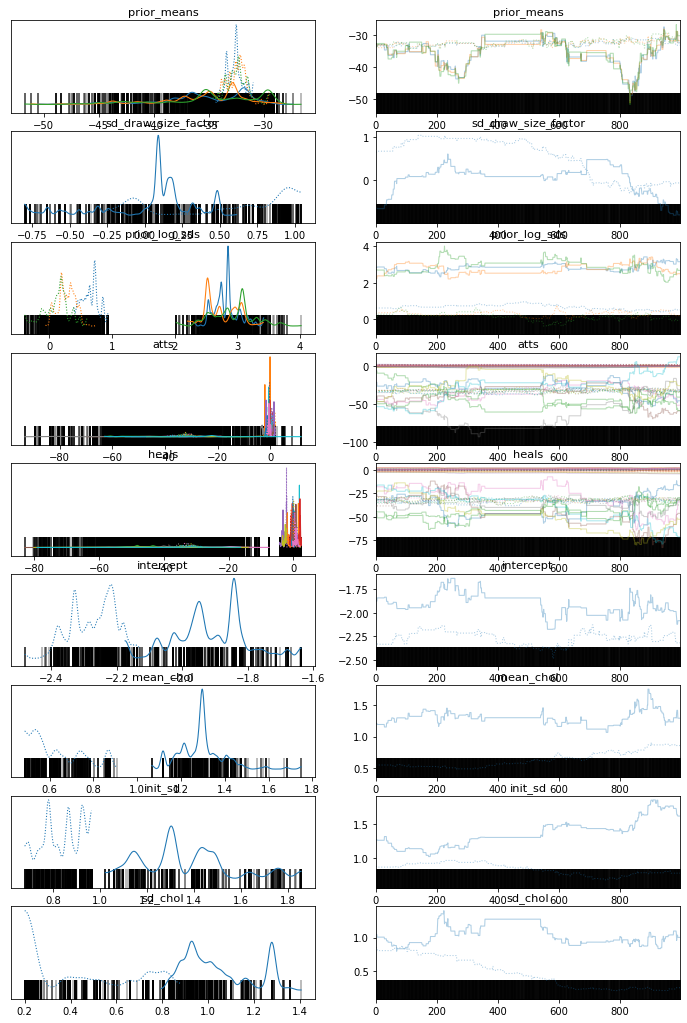

In [13]:
# Sampling!
with hierarchical_model:
    hierarchical_trace = pm.sample(draws=1000, tune=1000)
    pm.traceplot(hierarchical_trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/plots/plot_utils.py:277: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (51) in plot_posterior, generating only 40 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5a1779bd0>,
      dtype=object)

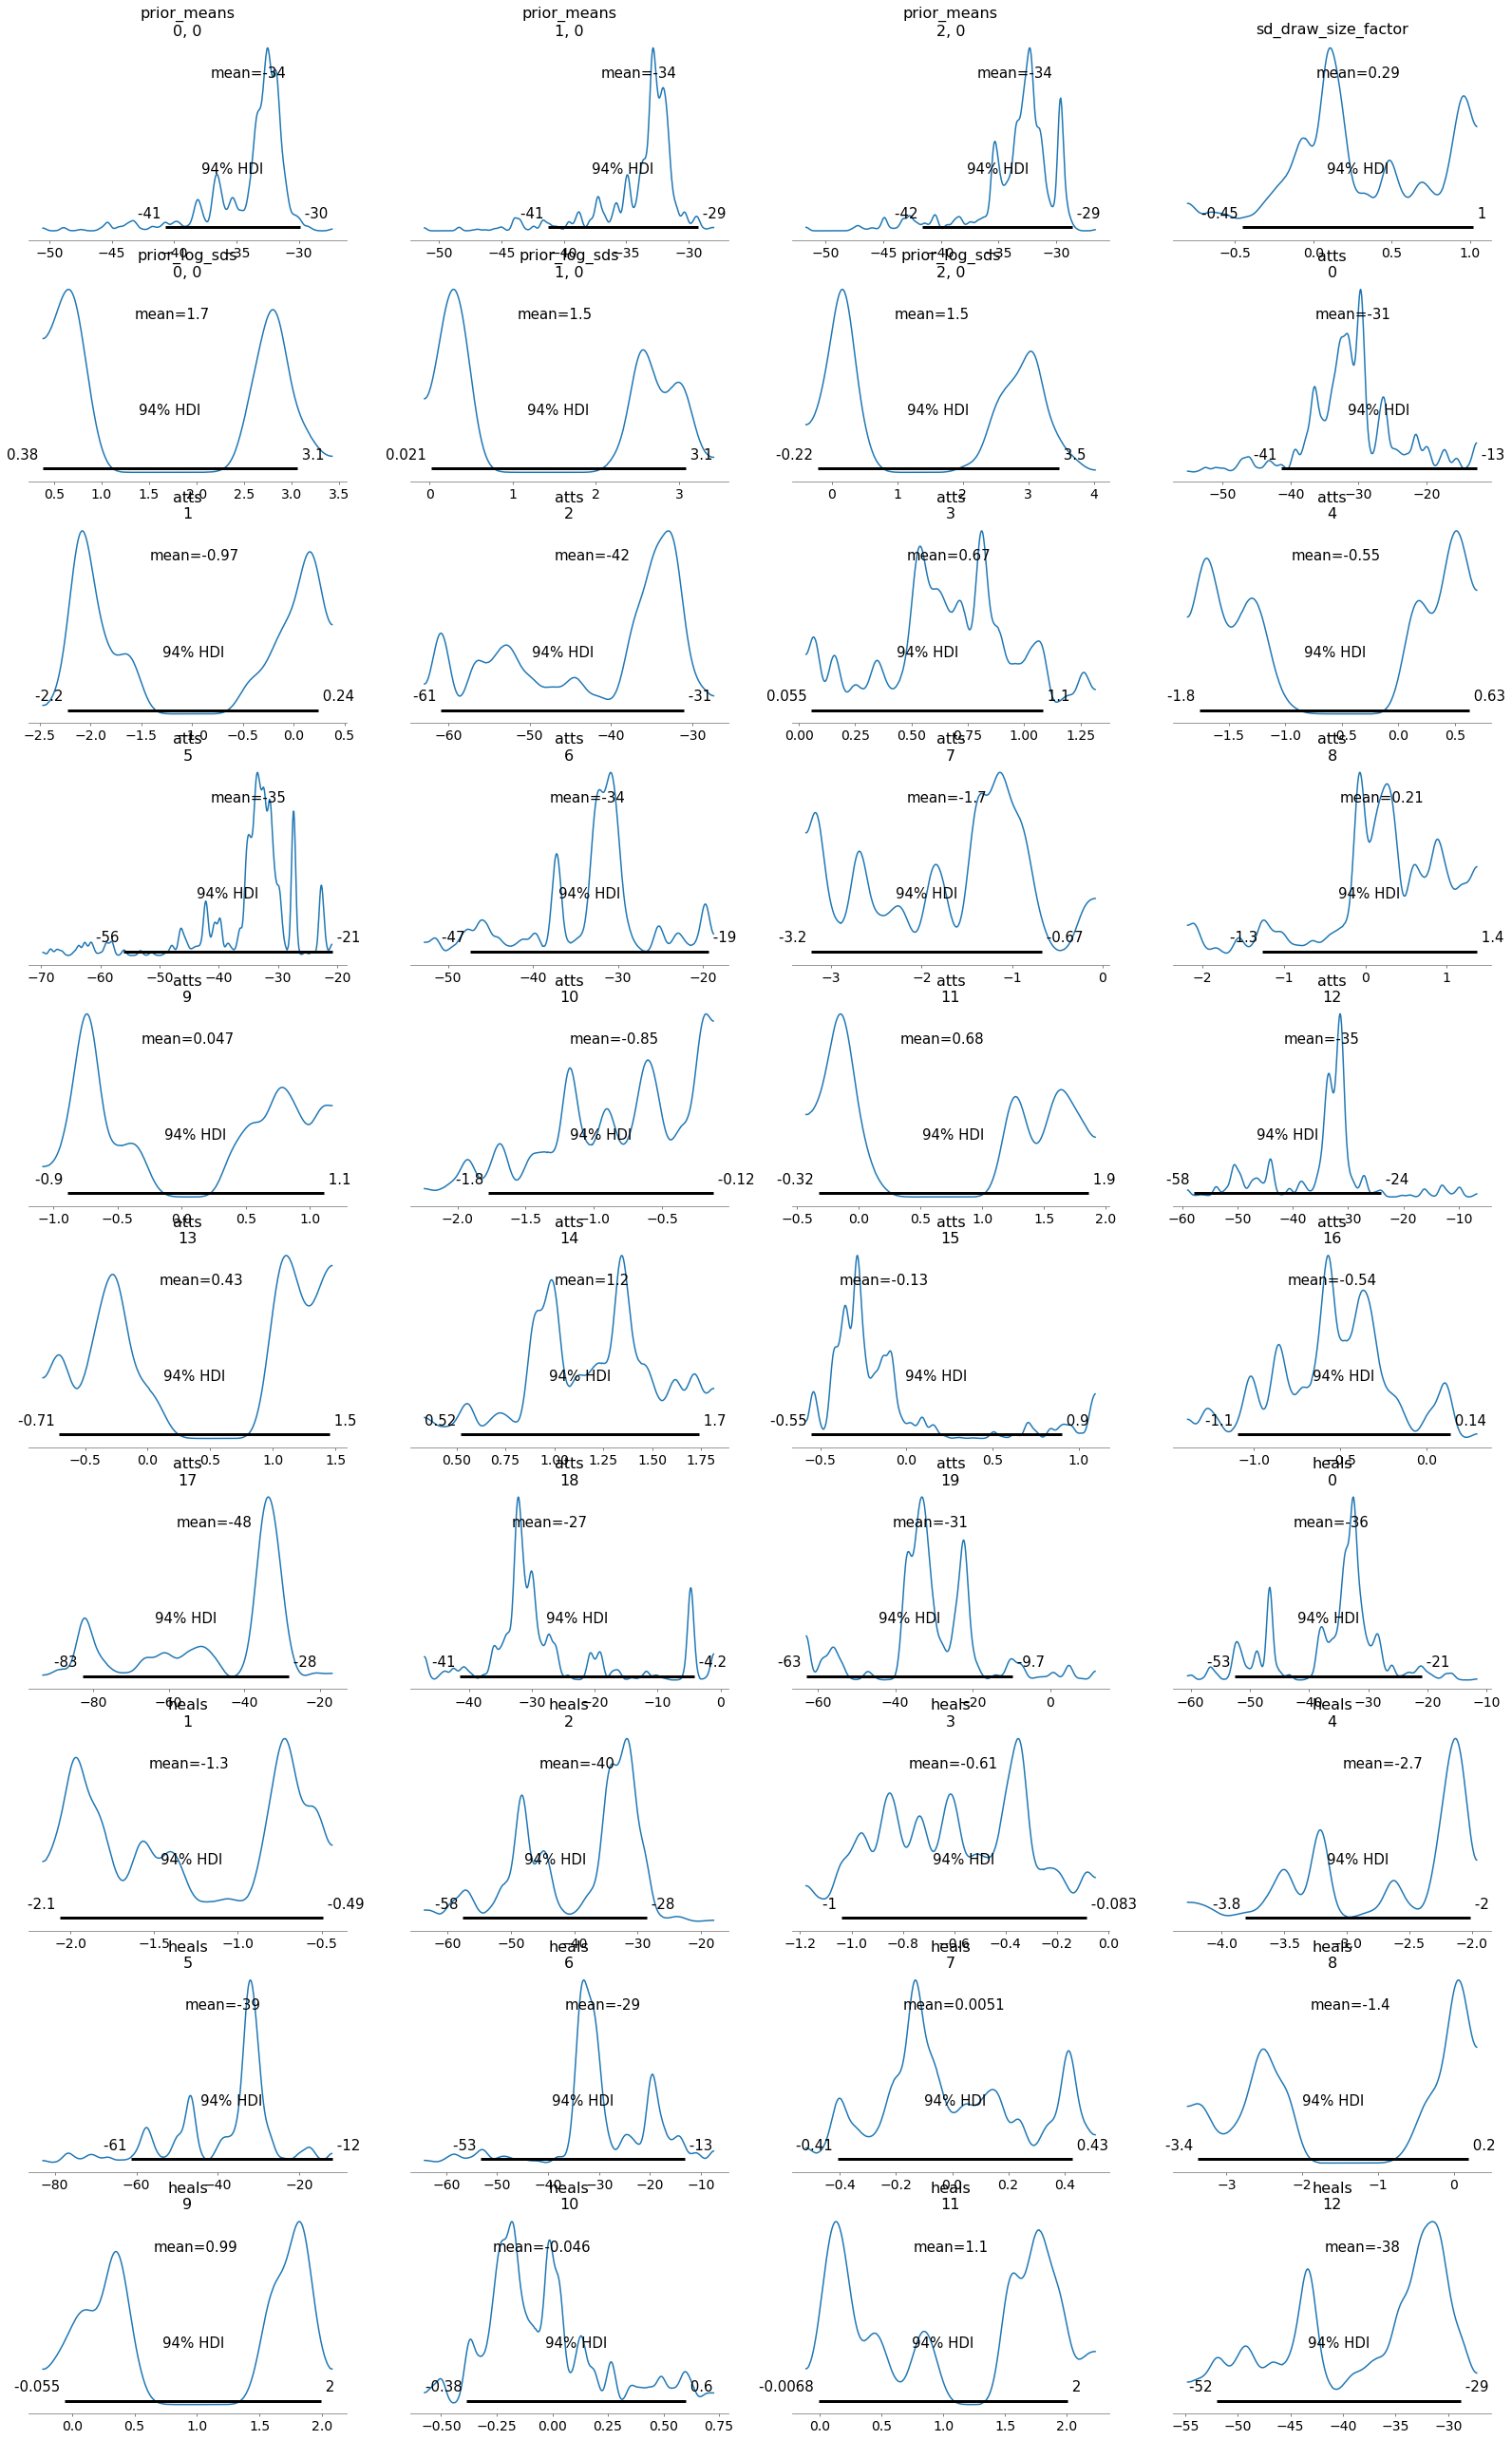

In [14]:
az.plot_posterior(hierarchical_trace)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


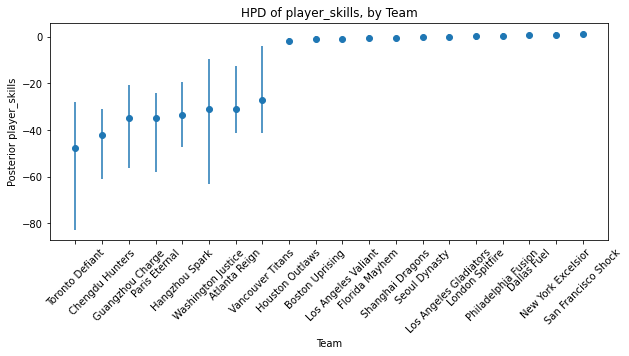

In [15]:
# hierarchical_trace['player_skills'].shape
# df_hpd = pd.DataFrame(az.hdi(hierarchical_trace['player_skills']),
#                       columns=['hpd_low', 'hpd_high'],
#                       index=names)
# df_median = pd.DataFrame(hierarchical_trace['player_skills'].mean(axis=0),
#                          columns=['hpd_median'],
#                          index=names)

# df_hpd = df_hpd.join(df_median)
# df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
# df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
# df_hpd = df_hpd.sort_values(by='hpd_median')
# df_hpd = df_hpd.reset_index()
# df_hpd['x'] = df_hpd.index + .5

# fig, axs = plt.subplots(figsize=(10,4))
# axs.errorbar(df_hpd.x, df_hpd.hpd_median,
#              yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
#              fmt='o')
# axs.set_title('HPD of player_skills, by Team')
# axs.set_xlabel('Team')
# axs.set_ylabel('Posterior player_skills')
# _= axs.set_xticks(df_hpd.index + .5)
# _= axs.set_xticklabels(df_hpd['index'].values, rotation=45)
hierarchical_trace['atts'].shape
df_hpd = pd.DataFrame(az.hdi(hierarchical_trace['atts']),
                      columns=['hpd_low', 'hpd_high'],
                      index=names)
df_median = pd.DataFrame(hierarchical_trace['atts'].mean(axis=0),
                         columns=['hpd_median'],
                         index=names)

df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5

fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of player_skills, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior player_skills')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

In [16]:
# player_means = hierarchical_trace['player_skills'].mean(axis=0)
# player_sds = hierarchical_trace['player_skills'].std(axis=0)
# player_mean_series = pd.Series(player_means, index=encoder.classes_)
# player_sd_series = pd.Series(player_sds, index=encoder.classes_)
# player_results = pd.concat([player_mean_series, player_sd_series], axis=1, keys=['mean', 'sd'])
# player_results.sort_values(by='mean', ascending=False).round(3).head(20)
player_means = hierarchical_trace['atts'].mean(axis=0)
player_sds = hierarchical_trace['atts'].std(axis=0)
player_mean_series = pd.Series(player_means, index=encoder.classes_)
player_sd_series = pd.Series(player_sds, index=encoder.classes_)
player_results = pd.concat([player_mean_series, player_sd_series], axis=1, keys=['mean', 'sd'])
player_results.sort_values(by='mean', ascending=False).round(3).head(20)

,mean,sd
San Francisco Shock,1.191,0.330
New York Excelsior,0.676,0.859
Dallas Fuel,0.665,0.297
Philadelphia Fusion,0.427,0.804
London Spitfire,0.207,0.774
Los Angeles Gladiators,0.047,0.761
Seoul Dynasty,-0.130,0.394
Shanghai Dragons,-0.543,0.335
Florida Mayhem,-0.551,0.962
Los Angeles Valiant,-0.849,0.527


In [23]:
with hierarchical_model:
    pp_trace = pm.sample_posterior_predictive(
        hierarchical_trace, var_names=["atts", "heals", "win_lik"])

In [24]:
az.plot_ppc(az.from_pymc3(posterior_predictive=pp_trace, model=hierarchical_model));

KeyError: ignored